<a href="https://colab.research.google.com/github/yankikalfa/SAIS-ML-for-Finance/blob/main/ARMA_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 1: ARMA Models
## Objectives
* Dowload Data from Yahoo Finance
* Check Statistical Properties of AAPL
* H Step Ahead Forecasts
  * AR
  * MA
  * ARMA
* Lag Length Selection
  * AIC
  * BIC
* Automatic Lag Selection

## Dowload and Import Libraries

In [ ]:
! pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 13.8 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
! pip install statsmodels -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 8.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
! pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 9.3 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
plt.style.use('bmh')


## Dowload Data from Yahoo Finance

In [ ]:
import yfinance as yf

In [ ]:
aapl=pd.DataFrame(yf.download('aapl', start='2010-01-01')['Adj Close'] )

[*********************100%***********************]  1 of 1 completed


In [ ]:
aapl

,Adj Close
Date,
2010-01-04,6.535085
2010-01-05,6.546383
2010-01-06,6.442256
2010-01-07,6.430345
2010-01-08,6.473096
...,...
2022-06-07,148.710007
2022-06-08,147.960007
2022-06-09,142.639999


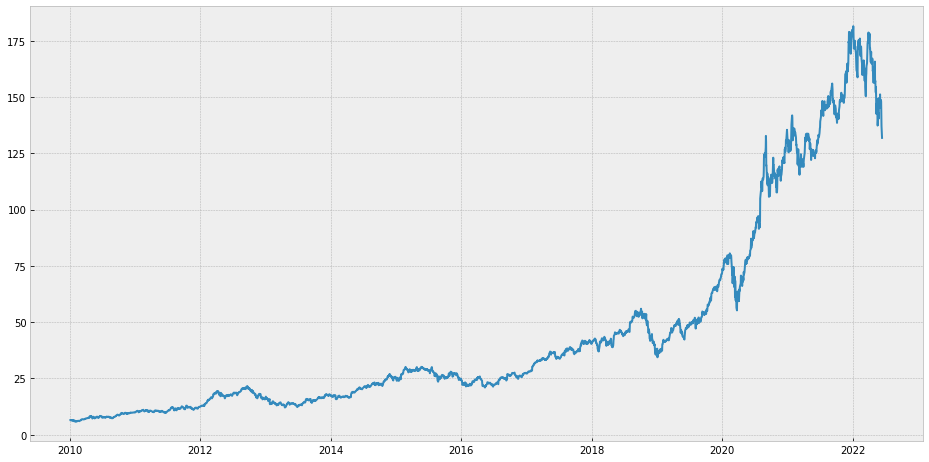

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(aapl)

## Statistical Properties

We will first check the Autocorelation function

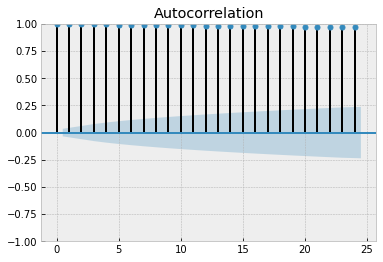

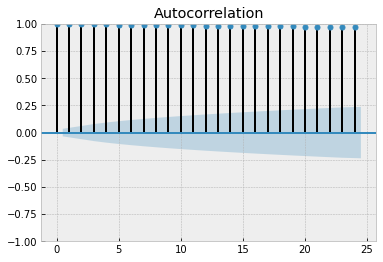

In [ ]:
sm.graphics.tsa.plot_acf(aapl['Adj Close'].squeeze(), lags=24)

We see that almost all autocorrelation is around 1, which is a pretty good indicator that the series is non-stationary.

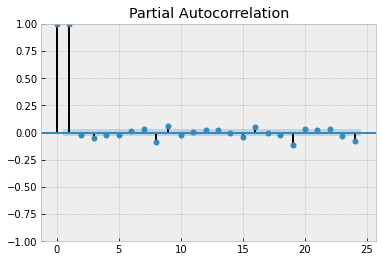

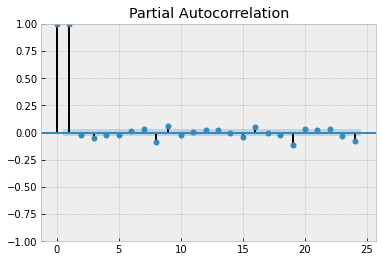

In [ ]:
sm.graphics.tsa.plot_pacf(aapl['Adj Close'].squeeze(), lags=24)

The Partial ACF shows that the first 2 lags are close to 1, maybe we would need to include 2 lags in the AR model. So we have an AR(2)

Let's now check the Ljung-Box test of autocorrelation. In this case we have to define the lag length. 
$$Q_m = T\sum_{j=1}^m \hat{\rho}_{j}^2 \sim \chi_m^2$$

In [ ]:
sm.stats.acorr_ljungbox(aapl['Adj Close'], lags=[1], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,3128.844164,0.0,3125.850055,0.0


In [ ]:
sm.stats.acorr_ljungbox(aapl['Adj Close'], lags=[2], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
2,6251.33999,0.0,6244.361835,0.0


In [ ]:
sm.stats.acorr_ljungbox(aapl['Adj Close'], lags=[3], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
3,9367.005866,0.0,9355.058547,0.0


In [ ]:
sm.stats.acorr_ljungbox(aapl['Adj Close'], lags=[10], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,30973.375385,0.0,30899.465596,0.0


In [ ]:
sm.stats.acorr_ljungbox(aapl['Adj Close'], lags=[24], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
24,73152.801676,0.0,72817.03707,0.0


We see that the tested lag lengths all have significant autocorrelation. This is a pretty good indication that we can use the lagged values for forecasting. However, it could also mean that the series is not stationary.

### Augmented Dickey-Fuller (ADF) Tests

The ADF test is a work horse test for stationarity.
$$ y_t = \alpha + \phi y_{t-1} + \varepsilon_t $$
Estimating this equation and testing if $\phi=1$ causes problems becasue of possible unit roots. Hence, we adjust the test as follows:
$$y_t = \alpha + \phi y_{t-1} + \varepsilon_t\\
y_t -y_{t-1} = \alpha + (1-\phi) y_{t-1} + \varepsilon_t \\
\Delta y_{t} = \alpha + \varphi y_{t-1} + \varepsilon_t $$ 
And we test the null of $ H_0: \varphi=0$, if we fail to reject the null, then it must be that $\phi=1$ and therefore the series is unit root.

There are 3 main specifications of the ADF test:
$$\text{No Constant: }\Delta y_{t} = \varphi y_{t-1} + \varepsilon_t\\
\text{Constant: }\Delta y_{t} = \alpha + \varphi y_{t-1} + \varepsilon_t \\
\text{Constant and Trend: }\Delta y_{t} = \alpha + \delta_t+ \varphi y_{t-1} + \varepsilon_t$$

These specifications should be theoretically motivated, not including a constant assumes the mean is zero. Including a constant and trenc usually implies that the series increases exponentially. So be careful. As a rule of thumb **I test all three specifications**.

In [ ]:
def adf_test(timeseries,x):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, regression=x,autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

Testing the No-Constant specification

In [ ]:
adf_test(aapl,'n')

Results of Dickey-Fuller Test:
Test Statistic                    1.644089
p-value                           0.975901
#Lags Used                       29.000000
Number of Observations Used    3103.000000
Critical Value (1%)              -2.566461
Critical Value (5%)              -1.941087
Critical Value (10%)             -1.616735
dtype: float64


Testing the Constant specification

In [ ]:
adf_test(aapl,'c')

Results of Dickey-Fuller Test:
Test Statistic                    0.385436
p-value                           0.980942
#Lags Used                       29.000000
Number of Observations Used    3103.000000
Critical Value (1%)              -3.432459
Critical Value (5%)              -2.862472
Critical Value (10%)             -2.567266
dtype: float64


Testing the Constant + Trend specification

In [ ]:
adf_test(aapl,'ct')

Results of Dickey-Fuller Test:
Test Statistic                   -1.328487
p-value                           0.880702
#Lags Used                       29.000000
Number of Observations Used    3103.000000
Critical Value (1%)              -3.961690
Critical Value (5%)              -3.411906
Critical Value (10%)             -3.127884
dtype: float64


All three specifications fail to reject the null of non-stationarity.
Therefore, we may need to difference the series. Usually we would take the first difference, however, in our case it might better to look at the daily continuously compounded returns.

### Transformation

In [ ]:
aapl['r']= np.log(aapl['Adj Close']).diff()

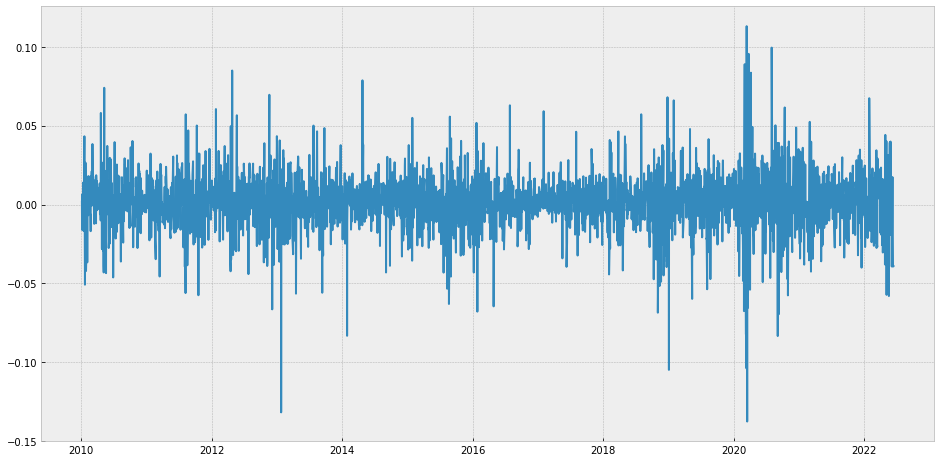

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(aapl['r'])

Immediately we can see that returns are more distributed as WN. Let's run some more tests.

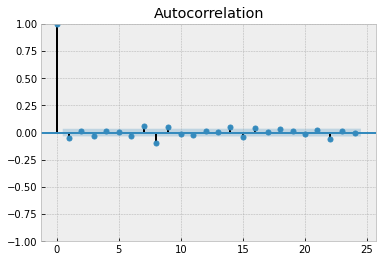

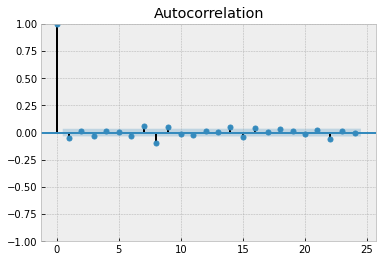

In [ ]:
sm.graphics.tsa.plot_acf(aapl['r'].dropna().squeeze(), lags=24)

We see that only the first autocorrelation is around 1. 

In [ ]:
sm.stats.acorr_ljungbox(aapl['r'].dropna(), lags=[1], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,6.701906,0.009631,6.695491,0.009666


In [ ]:
sm.stats.acorr_ljungbox(aapl['r'].dropna(), lags=[2], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
2,7.116131,0.028494,7.109187,0.028593


In [ ]:
sm.stats.acorr_ljungbox(aapl['r'].dropna(), lags=[3], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
3,10.353354,0.015789,10.341245,0.015877


In [ ]:
sm.stats.acorr_ljungbox(aapl['r'].dropna(), lags=[5], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
5,11.449755,0.043157,11.435526,0.043397


In [ ]:
sm.stats.acorr_ljungbox(aapl['r'].dropna(), lags=[10], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,62.76762,1.081105e-09,62.592064,1.167586e-09


The Ljung Box test show that there is still significant autocorrelation, this is a good sign, it means that we can use that forecast the series.

In [ ]:
adf_test(aapl.r.dropna(),'n')

Results of Dickey-Fuller Test:
Test Statistic                -1.098502e+01
p-value                        7.723875e-20
#Lags Used                     2.100000e+01
Number of Observations Used    3.110000e+03
Critical Value (1%)           -2.566459e+00
Critical Value (5%)           -1.941087e+00
Critical Value (10%)          -1.616735e+00
dtype: float64


In [ ]:
adf_test(aapl.r.dropna(),'c')

Results of Dickey-Fuller Test:
Test Statistic                -1.856896e+01
p-value                        2.083553e-30
#Lags Used                     8.000000e+00
Number of Observations Used    3.123000e+03
Critical Value (1%)           -3.432446e+00
Critical Value (5%)           -2.862466e+00
Critical Value (10%)          -2.567263e+00
dtype: float64


In [ ]:
adf_test(aapl.r.dropna(),'ct')

Results of Dickey-Fuller Test:
Test Statistic                  -18.565841
p-value                           0.000000
#Lags Used                        8.000000
Number of Observations Used    3123.000000
Critical Value (1%)              -3.961672
Critical Value (5%)              -3.411897
Critical Value (10%)             -3.127878
dtype: float64


We reject the null of non-stationarity in all three cases. Which means that we are good to forecast returns using ARMA models.

## Forecasting Models

We need to first split our data into the estimation (training) and testing samples

In [ ]:
df_train = pd.DataFrame(aapl['r'].iloc[:-30].dropna())
df_test = pd.DataFrame(aapl['r'].iloc[-30:])

In [ ]:
df_train

,r
Date,
2010-01-05,0.001727
2010-01-06,-0.016034
2010-01-07,-0.001851
2010-01-08,0.006626
2010-01-11,-0.008861
...,...
2022-04-25,0.006715
2022-04-26,-0.038043
2022-04-27,-0.001468


In [ ]:
df_test

,r
Date,
2022-05-02,0.001965
2022-05-03,0.009577
2022-05-04,0.040190
2022-05-05,-0.057328
2022-05-06,0.004716
2022-05-09,-0.033752
2022-05-10,0.015984
2022-05-11,-0.053233
2022-05-12,-0.027262


### AR Models

In [ ]:
ar1 = ARIMA(df_train['r'],order=(1,0,0))
ar1_results = ar1.fit()
ar1_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      r   No. Observations:                 3102
Model:                 ARIMA(1, 0, 0)   Log Likelihood                8109.577
Date:                Mon, 13 Jun 2022   AIC                         -16213.155
Time:                        22:47:31   BIC                         -16195.036
Sample:                             0   HQIC                        -16206.649
                               - 3102                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      3.317      0.001       0.000       0.002
ar.L1         -0.0464      0.012     -3.979      0.000      -0.069      -0.024
sigma2         0.0003   4.33e-06     72.449      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4176.13
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
ar1_is = ar1_results.predict()

In [ ]:
ar2 = ARIMA(df_train['r'],order=(2,0,0))
ar2_results = ar2.fit()
ar2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      r   No. Observations:                 3102
Model:                 ARIMA(2, 0, 0)   Log Likelihood                8109.690
Date:                Mon, 13 Jun 2022   AIC                         -16211.381
Time:                        22:47:32   BIC                         -16187.222
Sample:                             0   HQIC                        -16202.706
                               - 3102                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      3.200      0.001       0.000       0.002
ar.L1         -0.0460      0.012     -3.784      0.000      -0.070      -0.022
ar.L2          0.0085      0.012      0.714      0.475      -0.015       0.032
sigma2         0.0003   4.34e-06     72.253      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4171.27
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
ar2_is = ar2_results.predict()

In [ ]:
df_train=pd.concat([df_train,ar1_is,ar2_is],axis=1)
df_train.columns=['r','ar1_is','ar2_is']

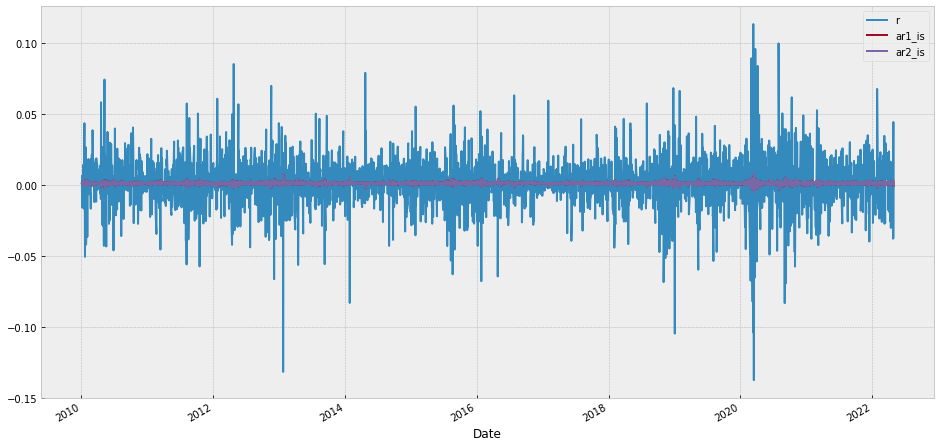

In [ ]:
df_train.plot(figsize=(16,8))

### MA Models

In [ ]:
ma1 = ARIMA(df_train['r'],order=(0,0,1))
ma1_results = ma1.fit()
ma1_results.summary()
ma1_is = ma1_results.predict()

ma2 = ARIMA(df_train['r'],order=(0,0,2))
ma2_results = ma2.fit()
ma2_results.summary()
ma2_is = ma2_results.predict()

df_train=pd.concat([df_train,ma1_is,ma2_is],axis=1)
df_train.columns=['r','ar1_is','ar2_is','ma1_is','ma2_is']


In [ ]:
ma1_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      r   No. Observations:                 3102
Model:                 ARIMA(0, 0, 1)   Log Likelihood                8109.522
Date:                Mon, 13 Jun 2022   AIC                         -16213.045
Time:                        22:47:43   BIC                         -16194.925
Sample:                             0   HQIC                        -16206.538
                               - 3102                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      3.309      0.001       0.000       0.002
ma.L1         -0.0458      0.012     -3.843      0.000      -0.069      -0.022
sigma2         0.0003   4.34e-06     72.345      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4183.00
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
ma2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      r   No. Observations:                 3102
Model:                 ARIMA(0, 0, 2)   Log Likelihood                8109.619
Date:                Mon, 13 Jun 2022   AIC                         -16211.237
Time:                        22:47:43   BIC                         -16187.078
Sample:                             0   HQIC                        -16202.562
                               - 3102                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      3.193      0.001       0.000       0.002
ma.L1         -0.0457      0.012     -3.756      0.000      -0.070      -0.022
ma.L2          0.0098      0.012      0.833      0.405      -0.013       0.033
sigma2         0.0003   4.34e-06     72.274      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4171.46
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

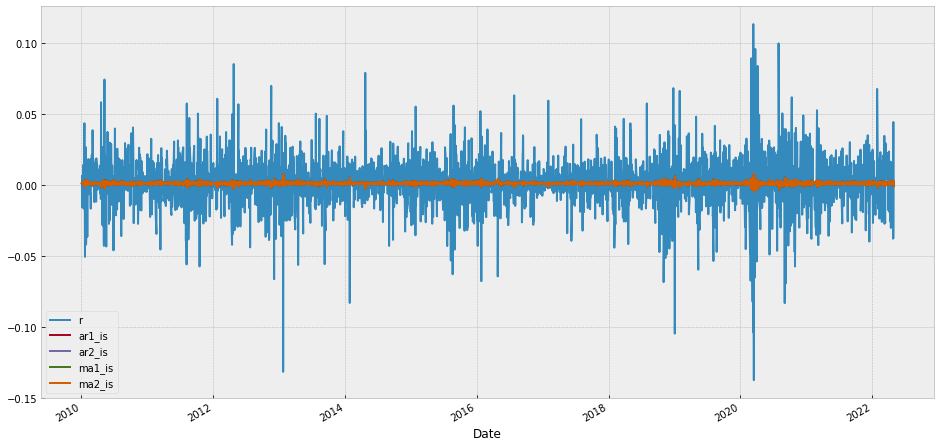

In [ ]:
df_train.plot(figsize=(16,8))

### ARMA Models

In [ ]:
arma1 = ARIMA(df_train['r'],order=(1,0,1))
arma1_results = arma1.fit()
arma1_results.summary()
arma1_is = arma1_results.predict()

arma2 = ARIMA(df_train['r'],order=(2,0,2))
arma2_results = arma2.fit()
arma2_results.summary()
arma2_is = arma2_results.predict()

df_train=pd.concat([df_train,arma1_is,arma2_is],axis=1)
df_train.columns=['r','ar1_is','ar2_is','ma1_is','ma2_is','arma1','arma2']

In [ ]:
arma1_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      r   No. Observations:                 3102
Model:                 ARIMA(1, 0, 1)   Log Likelihood                8109.956
Date:                Mon, 13 Jun 2022   AIC                         -16211.913
Time:                        22:47:48   BIC                         -16187.754
Sample:                             0   HQIC                        -16203.238
                               - 3102                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      3.240      0.001       0.000       0.002
ar.L1         -0.3301      0.220     -1.498      0.134      -0.762       0.102
ma.L1          0.2843      0.224      1.267      0.205      -0.155       0.724
sigma2         0.0003   4.34e-06     72.202      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4184.52
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
arma2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      r   No. Observations:                 3102
Model:                 ARIMA(2, 0, 2)   Log Likelihood                8109.748
Date:                Mon, 13 Jun 2022   AIC                         -16207.496
Time:                        22:47:48   BIC                         -16171.258
Sample:                             0   HQIC                        -16194.484
                               - 3102                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      3.153      0.002       0.000       0.002
ar.L1         -0.2224      1.020     -0.218      0.827      -2.222       1.777
ar.L2          0.2743      0.465      0.590      0.555      -0.637       1.186
ma.L1          0.1767      1.017      0.174      0.862      -1.817       2.170
ma.L2         -0.2746      0.423     -0.650      0.516      -1.103       0.554
sigma2         0.0003   4.45e-06     70.469      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4252.25
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

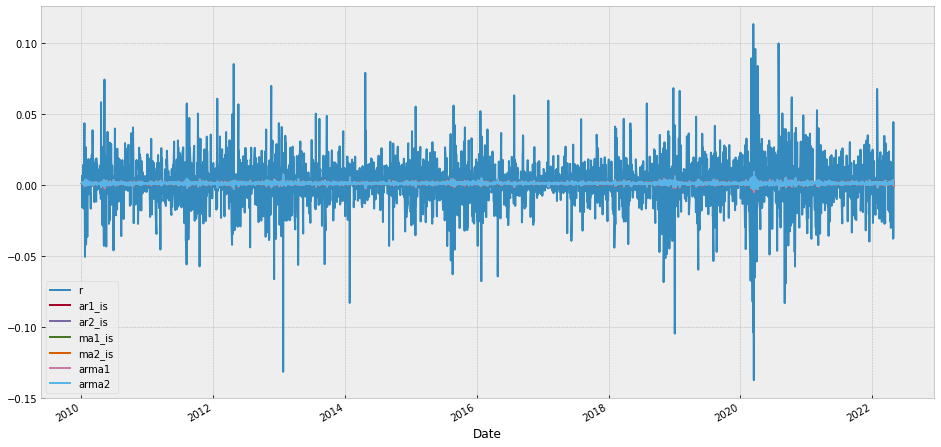

In [ ]:
df_train.plot(figsize=(16,8))

## Pseudo Out-of-Sample Forecasts

In [ ]:
start=len(aapl['r'].iloc[:-30])
end=len(aapl)-1
ar1_oos = pd.DataFrame(ar1_results.predict(start=start, end=end,
                                          typ='levels').rename('ar1_oos'))

In [ ]:
ar2_oos = pd.DataFrame(ar2_results.predict(start=start, end=end,
                                          typ='levels').rename('ar2_oos'))
ma1_oos = pd.DataFrame(ma1_results.predict(start=start, end=end,
                                          typ='levels').rename('ma1_oos'))
ma2_oos = pd.DataFrame(ma2_results.predict(start=start, end=end,
                                          typ='levels').rename('ma2_oos'))

arma1_oos = pd.DataFrame(arma1_results.predict(start=start, end=end,
                                          typ='levels').rename('arma1_oos'))
arma2_oos = pd.DataFrame(arma2_results.predict(start=start, end=end,
                                          typ='levels').rename('arma2_oos'))



In [ ]:
len(ar1_oos)

30

In [ ]:
ar1_oos.set_index(df_test.index.copy(),inplace=True)
ar2_oos.set_index(df_test.index.copy(),inplace=True)
ma1_oos.set_index(df_test.index.copy(),inplace=True)
ma2_oos.set_index(df_test.index.copy(),inplace=True)
arma1_oos.set_index(df_test.index.copy(),inplace=True)
arma2_oos.set_index(df_test.index.copy(),inplace=True)


In [ ]:
df_test=pd.concat([df_test,ar1_oos,ar2_oos,ma1_oos,ma2_oos,arma1_oos,arma2_oos],axis=1)

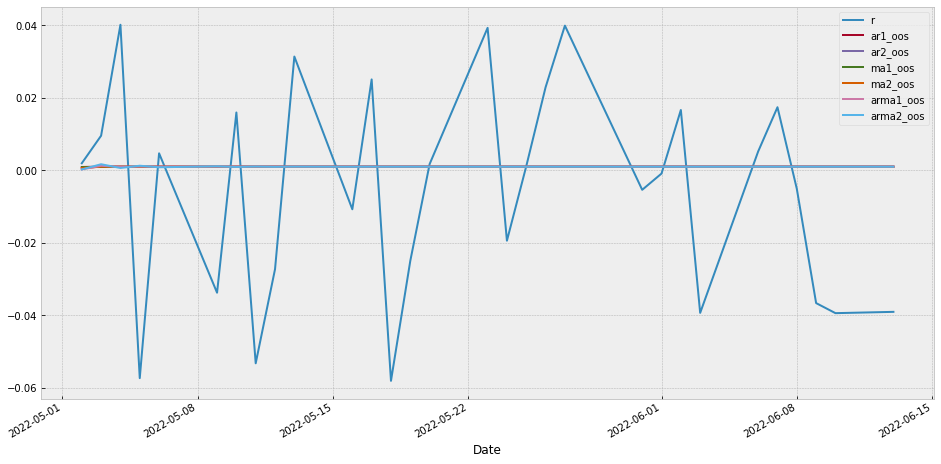

In [ ]:
df_test.plot(figsize=(16,8))

We can see that the model is not performing well in the out of sample. This is due to couple of reasons, first, these are 30 day ahead forecasts, we cannot expect them to perform well after 1 day. Second, the shocks to returns are just not predictable. It could also be that we are missing out some indicators that could help forecast returns.

## ARIMA Models

After running the ADF test we said that the series is not stationary and decided to work with returns. Can we use level of the series instead of returns?

Yes, we call these models Autoregressive Integrated Moving Average models. We know that the series becomes stationary after taking the first difference, therefore it is integrated of order 1, we call this an I(1) series.


In [ ]:
df_train_arima = pd.DataFrame(np.log(aapl['Adj Close'].iloc[:-30]))
df_test_arima = pd.DataFrame(np.log(aapl['Adj Close'].iloc[-30:]))

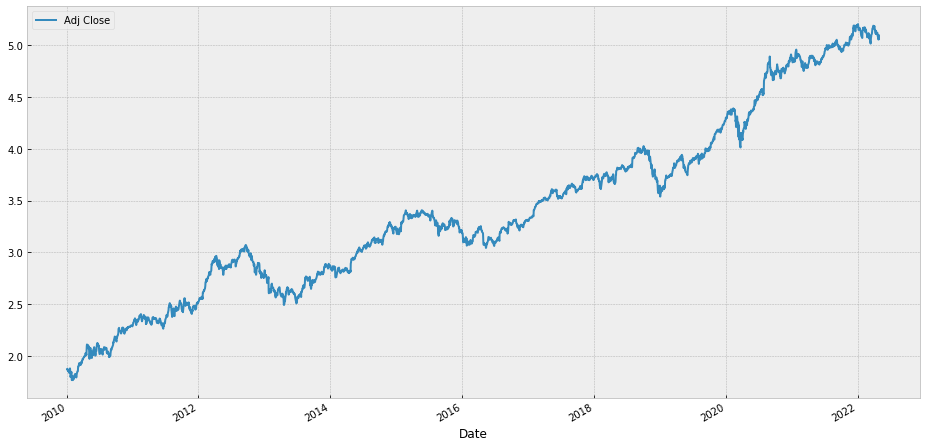

In [ ]:
df_train_arima.plot(figsize=(16,8))

In [ ]:
arima1 = ARIMA(df_train_arima['Adj Close'],order=(1,1,1))
arima1_results = arima1.fit()
arima1_results.summary()
arima1_is = arima1_results.predict()

arima2 = ARIMA(df_train_arima['Adj Close'],order=(2,1,2))
arima2_results = arima2.fit()
arima2_results.summary()
arima2_is = arima2_results.predict()

In [ ]:
arima1_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 3103
Model:                 ARIMA(1, 1, 1)   Log Likelihood                8104.490
Date:                Tue, 14 Jun 2022   AIC                         -16202.979
Time:                        04:02:10   BIC                         -16184.860
Sample:                             0   HQIC                        -16196.473
                               - 3103                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4521      0.192     -2.358      0.018      -0.828      -0.076
ma.L1          0.4100      0.195      2.099      0.036       0.027       0.793
sigma2         0.0003   4.37e-06     72.070      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              4230.17
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
arima2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 3103
Model:                 ARIMA(2, 1, 2)   Log Likelihood                8104.270
Date:                Tue, 14 Jun 2022   AIC                         -16198.541
Time:                        04:02:10   BIC                         -16168.342
Sample:                             0   HQIC                        -16187.697
                               - 3103                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4686      2.394     -0.196      0.845      -5.161       4.224
ar.L2          0.0715      1.076      0.066      0.947      -2.038       2.181
ma.L1          0.4267      2.393      0.178      0.858      -4.264       5.117
ma.L2         -0.0777      0.981     -0.079      0.937      -2.001       1.845
sigma2         0.0003   4.44e-06     70.939      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              4253.72
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
df_train_arima=pd.concat([df_train_arima,arima1_is,arima2_is],axis=1)
df_train_arima.columns=['price', 'arima1_is','arima2_is']

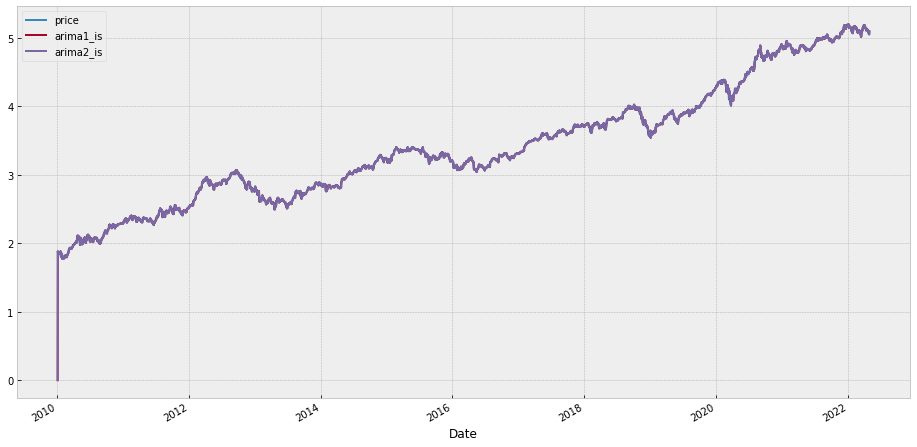

In [ ]:
df_train_arima.plot(figsize=(16,8))

The insample fit is not bad, let's look at the out of sample performance

In [ ]:
start=len(aapl['Adj Close'].iloc[:-30])
end=len(aapl)-1
arima1_oos = pd.DataFrame(arima1_results.predict(start=start, end=end,
                                          typ='levels').rename('arima1_oos'))
arima2_oos = pd.DataFrame(arima2_results.predict(start=start, end=end,
                                          typ='levels').rename('arima2_oos'))


In [ ]:
arima1_oos.set_index(df_test_arima.index.copy(),inplace=True)
arima2_oos.set_index(df_test_arima.index.copy(),inplace=True)

df_test_arima=pd.concat([df_test_arima,arima1_oos,arima2_oos],axis=1)
df_test_arima.columns=['price', 'arima1_oos','arima2_oos']

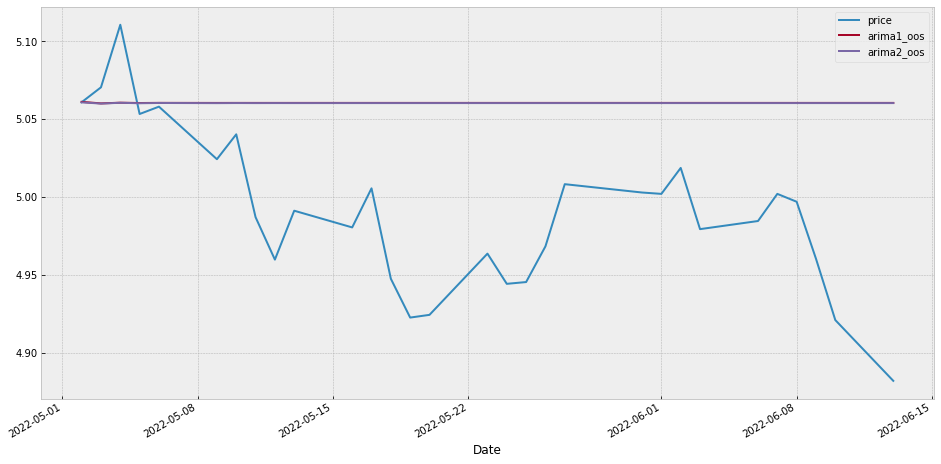

In [ ]:
df_test_arima.plot(figsize=(16,8))

It is still very poor.

## Lag Length Selection with Information Criterion

In the above models we just picked a lag order. However, it is usually better practice to use an Information Criterion to select the lag orders

In [ ]:
import itertools

In [ ]:
def AIC_PDQ(df,ar,ii,ma): 

# Define the p, d and q parameters to take any value between 0 and 2
    p = range(0,ar)
    d = range(0,ii)
    q = range(0, ma)

# Auto-Regressive (p) -> Number of autoregressive terms.
# Integrated (d) -> Number of nonseasonal differences needed for stationarity.
# Moving Average (q) -> Number of lagged forecast errors in the prediction equation.
# Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
# Run a grid with pdq and seasonal pdq parameters calculated above and get #the best AIC value
    ans = []
    for comb in pdq:
      try:
          mod = ARIMA(df,
                      order=comb,
                      enforce_stationarity=True,
                      enforce_invertibility=True)
          
          output = mod.fit()
          ans.append([comb, output.aic])
          print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, output.aic))
      except:
        continue
# Find the parameters with minimal AIC value
    ans_df = pd.DataFrame(ans, columns=['pdq', 'aic'])
    print(ans_df.loc[ans_df['aic'].idxmin()])
    return ans_df

In [ ]:
def BIC_PDQ(df,ar,ii,ma): 

# Define the p, d and q parameters to take any user defined value. We need to be careful with integration order,
# cannot be 0.
    p = range(0,ar)
    d = range(0,ii)
    q = range(0, ma)

# Auto-Regressive (p) -> Number of autoregressive terms.
# Integrated (d) -> Number of nonseasonal differences needed for stationarity.
# Moving Average (q) -> Number of lagged forecast errors in the prediction equation.
# Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
# Run a grid with pdq and seasonal pdq parameters calculated above and get #the best AIC value
    ans = []
    for comb in pdq:
      try:
          mod = ARIMA(df,
                      order=comb,
                      enforce_stationarity=True,
                      enforce_invertibility=True)
          
          output = mod.fit()
          ans.append([comb, output.aic])
          print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, output.bic))
      except:
        continue
# Find the parameters with minimal AIC value
    ans_df = pd.DataFrame(ans, columns=['pdq', 'bic'])
    print(ans_df.loc[ans_df['bic'].idxmin()])
    return ans_df


In [ ]:
AIC_PDQ(df_train.iloc[:,0],2,1,2)

pdq       (1, 0, 0)
aic   -16213.154961
Name: 2, dtype: object


,pdq,aic
0,"(0, 0, 0)",-16208.487163
1,"(0, 0, 1)",-16213.044901
2,"(1, 0, 0)",-16213.154961
3,"(1, 0, 1)",-16211.912814


In [ ]:
BIC_PDQ(df_train.iloc[:,0],2,1,2)

pdq       (1, 0, 0)
bic   -16213.154961
Name: 2, dtype: object


,pdq,bic
0,"(0, 0, 0)",-16208.487163
1,"(0, 0, 1)",-16213.044901
2,"(1, 0, 0)",-16213.154961
3,"(1, 0, 1)",-16211.912814


In [ ]:
AIC_PDQ(df_train_arima.iloc[:,0],2,2,2)

pdq       (1, 1, 0)
aic   -16203.819398
Name: 6, dtype: object


,pdq,aic
0,"(0, 0, 0)",7845.267122
1,"(0, 0, 1)",3640.711786
2,"(0, 1, 0)",-16200.129882
3,"(0, 1, 1)",-16203.684773
4,"(1, 0, 0)",-16192.325767
5,"(1, 0, 1)",-16195.847094
6,"(1, 1, 0)",-16203.819398
7,"(1, 1, 1)",-16202.979450


In [ ]:
BIC_PDQ(df_train_arima.iloc[:,0],2,2,2)

pdq       (1, 1, 0)
bic   -16203.819398
Name: 6, dtype: object


,pdq,bic
0,"(0, 0, 0)",7845.267122
1,"(0, 0, 1)",3640.711786
2,"(0, 1, 0)",-16200.129882
3,"(0, 1, 1)",-16203.684773
4,"(1, 0, 0)",-16192.325767
5,"(1, 0, 1)",-16195.847094
6,"(1, 1, 0)",-16203.819398
7,"(1, 1, 1)",-16202.979450


## Recursive Forecasting
We generated 30 step ahead forecasts. However, as mentioned that might not be the best idea. It is not realistic, especially in the finance world.

We will now focus on recursive forecasting schemes.


We will automatically select the best the lag for the model and generate 1 step-ahead forecasts for 30 periods

In [ ]:
import pmdarima as pm

In [ ]:
def recursive_arima(input_data, cc, p,q,cv_model):

    start = cc
    df_new = input_data.loc[:start-1]
    
    predicted_values = []

    
    for i in range(start,len(input_data)):
        if  cv_model =='I(0)':
            model = pm.auto_arima(df_new,start_p=0,max_p=p, start_q=0, max_q=q,d=0,stationary=True)
            results = model.fit(df_new)
          
        elif cv_model =='I(1)':
            model = pm.auto_arima(df_new,start_p=0,max_p=p, start_q=0, max_q=q,d=1,stationary=False)
            results = model.fit(df_new)
        else:
            raise Exception("Please input the model as 'I(0)' or 'I(1)'.")
        
        prediction_test = model.predict(n_periods=1)
        

        df_new = df_new.append(pd.Series(input_data.loc[start]))
        start += 1
        predicted_values.append(prediction_test[0])
    
    
    
    return predicted_values

  

    


In [ ]:
len(df_train)

3102

In [ ]:
aapl['r'].dropna().reset_index(drop=True).loc[3101]

-0.037291536195700914

In [ ]:
return_forecast=recursive_arima(aapl['r'].dropna().reset_index(drop=True),3102,6,6,'I(0)')

In [ ]:
rec_oos =pd.DataFrame(return_forecast)
rec_oos.set_index(df_test.index.copy(),inplace=True)
df_test=pd.concat([df_test,rec_oos],axis=1)


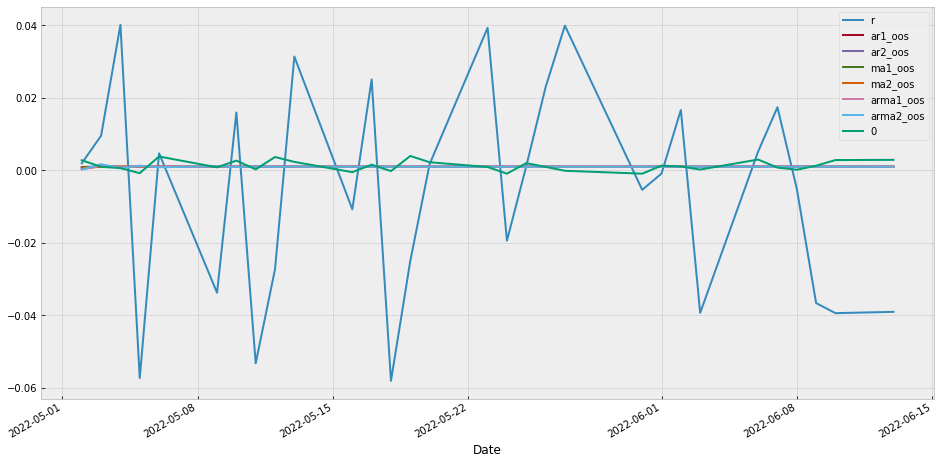

In [ ]:
df_test.plot(figsize=(16,8))

In [ ]:
price_forecast=recursive_arima(np.log(aapl['Adj Close'].reset_index(drop=True)),3103,6,6,'I(1)')

In [ ]:
i1_oos =pd.DataFrame(price_forecast)
i1_oos.set_index(df_test_arima.index.copy(),inplace=True)
df_test_arima=pd.concat([df_test_arima,i1_oos],axis=1)

In [ ]:
i1_oos

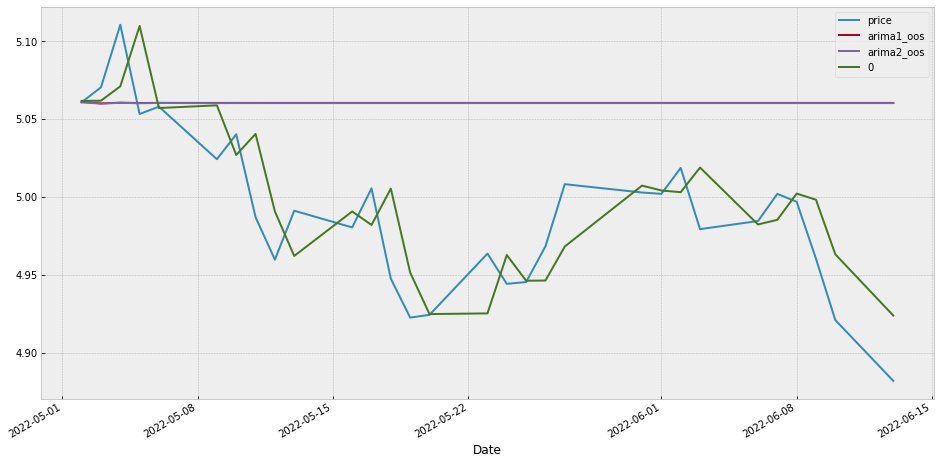

In [ ]:
df_test_arima.plot(figsize=(16,8))

Not terrible